In [1]:
from brian2 import *
from brian2.units import *
from brian2 import ms, mV, pA, pF, siemens, amp, second, NeuronGroup, defaultclock, run
from brian2tools import *
import matplotlib.pyplot as plt
import random
import numpy as np
import json

from models.AdEx import NeuronModel
from simulation_runner import run_simulation
from synapse import SynapseModel, connect
from params import load_params
from result import Visualization

import subprocess
from IPython.display import display, Markdown
from simulation_runner import convert_units, load_params, run_simulation

Unknown unit for u: mV / mS
Unknown unit for d: mv/second
Converted parameters: {'k': 1, 'v': -80. * mvolt, 'u': 0, 'vr': -64.4 * mvolt, 'vt': -50. * mvolt, 'a': 200. * mhertz, 'b': 25. * mhertz, 'C': 80. * pfarad, 'd': 0, 'I': 100. * pamp}


INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs/var
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs/var/folders
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs/var/folders/tj
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T
INFO:root:creating /var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs/var/folders/tj/9vhjqp2n63ng9609fgfkf_dc0000gn/T/brian_flag_test_arqzhtqs
INFO:root:arm64-apple-darwin20.0.0-clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch arm64 -fPIC -O2 -isystem /opt/anaconda3/envs/brain/include -arch

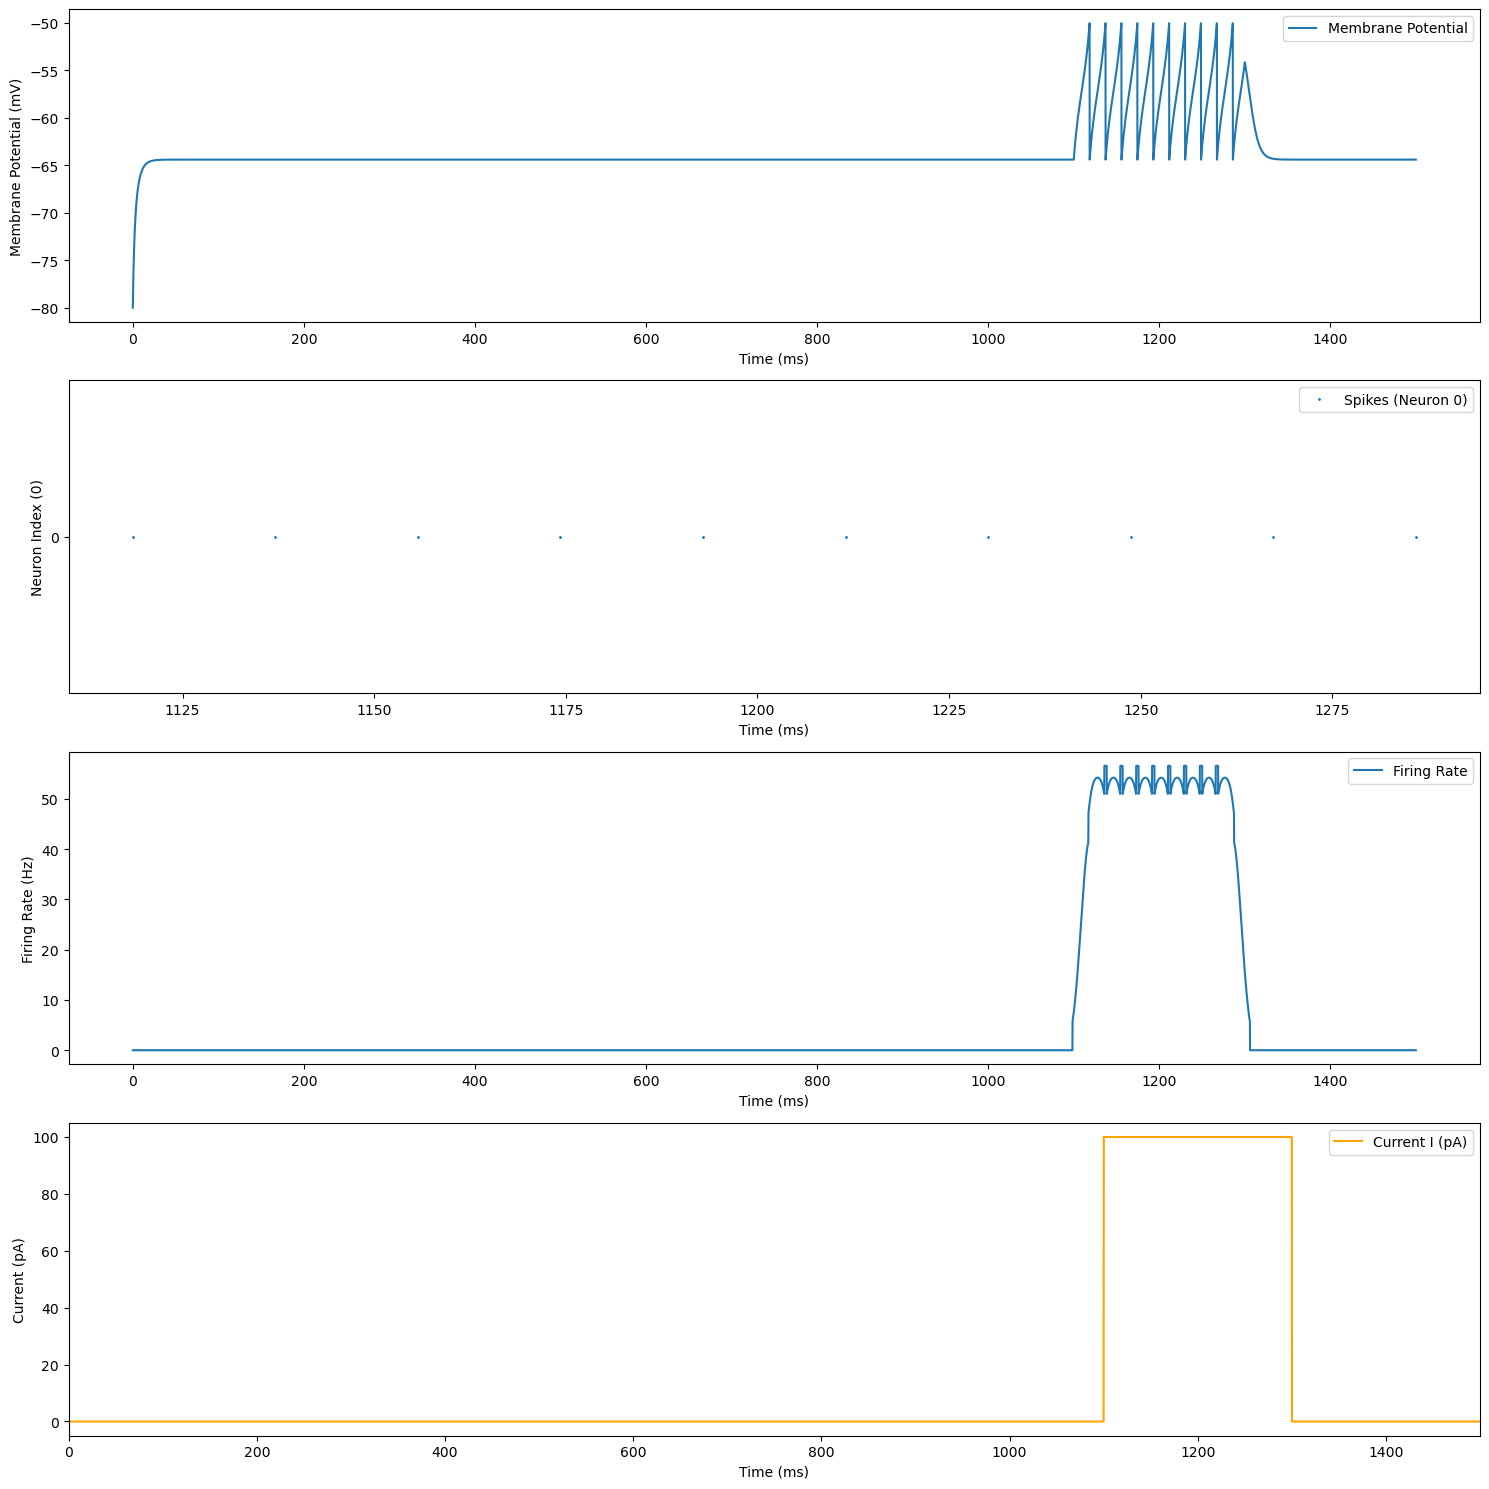

In [2]:
# JSON 파일 로드
json_file = './QIF.json'  # 사용할 JSON 파일 경로

# 파라미터 로드
params, model_name = load_params(json_file)
N = params.pop('N')['value']  # N은 모델의 뉴런 수

# 시뮬레이션 실행
neuron_model_class = NeuronModel  # 예시로 NeuronModel 클래스를 사용
sim = run_simulation(N, params, model_name)

# 결과 시각화
sim.plot_results()